In [61]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
import spacy
import re
import string
import pytesseract

from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

def show(image,figsize = (10,10)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()
    
def convert_rbg(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def cleanText(txt):
    
    whitespace = string.whitespace
    punctuation = '!#$%&\'()*+:;<=>?[\\]^`{|}~'
    tableWhitespace = str.maketrans('','',whitespace)
    tablePunctuation = str.maketrans('','',punctuation)
    
    text = str(txt)
    text = text.lower()
    removewhitespace = text.translate(tableWhitespace)
    removepunctuation = removewhitespace.translate(tablePunctuation)
    
    return str(removepunctuation)

def parser(text,label):
    
    if label == "PHONE":
        text = text.lower()
        text = re.sub("\D","",text)
        
    elif label == "EMAIL":
        text = text.lower()
        allow_special_chart = "@_.\-"
        text = re.sub(r"[^A-Za-z0-9{} ]".format(allow_special_chart),"",text)
        
    elif label == "WEB":
        text = text.lower()
        allow_special_chart = ":/.%#\-"
        text = re.sub(r"[^A-Za-z0-9{} ]".format(allow_special_chart),"",text)
        
    elif label in ("NAME","DES"):
        text = text.lower()
        text = re.sub(r"[^a-z ]","",text)
        text = text.title()
        
    elif label == "ORG":
        text = text.lower()
        text = re.sub(r"[^a-z0-9 ]","",text)
        text = text.title()
        
    return text

class groupgen():
    def __init__(self):
        self.id = 0
        self.text = ""
        
    def getgroup(self,text):
        if self.text == text:
            return self.id
        else:
            self.id+=1
            self.text = text
            return self.id
        
groupg = groupgen()

model_ner = spacy.load("./Output/model-best/")

img = cv2.imread("./example.jpg")

def getPredictions(image):
    
    tessData = pytesseract.image_to_data(image)
    tessList = list(map(lambda x : x.split("\t"), tessData.split("\n")))
    df = pd.DataFrame(tessList[1:],columns = tessList[0])
    df["text"] = df["text"].apply(cleanText)

    df_clean = df.query("text != '' ")
    df_clean = df_clean.query("text != ' ' ")
    
    content = " ".join([w for w in df_clean["text"]])
    #print(content)
    doc = model_ner(content)
    
    docjson = doc.to_json()
    print(docjson.keys())
    doc_text = docjson["text"]
    
    df_tokens = pd.DataFrame(docjson["tokens"]) # id, start, end 
    # Token add!! with docjson["text"]
    df_tokens["token"] = df_tokens[["start","end"]].apply(
        lambda x : doc_text[x[0]:x[1]], axis = 1)
    
    right_table = pd.DataFrame(docjson["ents"])[["start","label"]] # start,end,label = "B-Phone"
    df_tokens = pd.merge(df_tokens,right_table,how = "left",on = "start")
    df_tokens.fillna("O",inplace = True)
    
    # doesn't have end start --> df_clean
    df_clean["end"] = df_clean["text"].apply(lambda x : len(x)+1).cumsum() - 1
    df_clean["start"] = df_clean[["text","end"]].apply(lambda x : x[1] - len(x[0]), axis = 1)
    
    # df_tokens --> columns = ["id","start","end","token","label"]
    df_info = pd.merge(df_clean,df_tokens[["start","token","label"]],how = "inner",on = "start")
    
    # Bounding Box
    
    bb_df = df_info.query("label != 'O' ")
    
    # B-Phone I-Phone --> Phone 
    bb_df["label"] = bb_df["label"].apply(lambda x : x[2:])
    bb_df["group"] = bb_df["label"].apply(groupg.getgroup)
    
    bb_df[["left","top","width","height"]] = bb_df[["left","top","width","height"]].astype(int)
    bb_df["right"] = bb_df["left"] + bb_df["width"]
    bb_df["bottom"] = bb_df["top"] + bb_df["height"]
    
    col_group = ["left","top","right","bottom","label","token","group"]
    group_tag_img = bb_df[col_group].groupby(by = "group")
    img_taggging = group_tag_img.agg({
        "left":min,
        "right":max,
        "top":min,
        "bottom":max,
        "label" : np.unique,
        "token" : lambda x: " ".join(x)
    })
    
    img_bb = image.copy()
    for l,r,t,b,label,token in img_taggging.values:
        cv2.rectangle(img_bb,(l,t),(r,b),(0,255,0),2)
        cv2.putText(img_bb,str(label),(l,t),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2)
    
    info_array = df_info[["token","label"]].values
    entities = dict(NAME = [],ORG = [],DES = [],PHONE = [],EMAIL = [],WEB = [])
    previos = info_array[0][1]
    
    for token,label in info_array:
        bio_tag = label[0]
        label_tag = label[2:]
        
        text = parser(token,label_tag)
        
        if bio_tag in ("B","I"):
            
            if previos != label_tag:
                entities[label_tag].append(text)
                
            else:
                
                if bio_tag == "B" :
                        entities[label_tag].append(text)            
                else:
                    if label_tag in ("NAME","ORG","DES"):
                        entities[label_tag][-1] = entities[label_tag][-1] + " " + text
                    else:
                        entities[label_tag][-1] = entities[label_tag][-1] + text
                    
        previos = label_tag
    
    return img_bb,entities

dict_keys(['text', 'ents', 'tokens'])


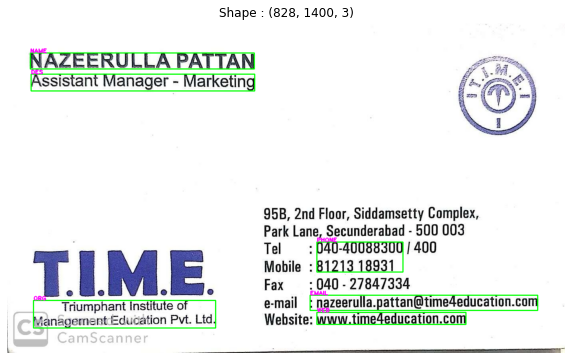

In [66]:
img_results,entities = getPredictions(cv2.imread("./Selected/151.jpeg"))
show(convert_rbg(img_results))